In [2]:
import numpy as np
import scipy
from scipy import integrate
from numpy.random import default_rng
from multiprocessing import Pool
import nfwFunctions as NFW
import inverseTransform
import time

from scipy import special
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

In [52]:
class halo():
    def __init__(self, rScale, rho0, delta, rhoCritical = 1.26*10**-7):
        self.rho0 = rho0
        self.rScale = rScale
        self.G = 4.3009*10**-3
        self.rhoCritical = rhoCritical
        self.delta = delta
        rhoNorm = rho0/(delta*rhoCritical)
        cShortcut = ((3.*np.sqrt(81.*rhoNorm**2. + 12.*rhoNorm) + 27.*rhoNorm + 2.)/2.)**(1./3.)
        self.c = ( cShortcut + 1./cShortcut - 2 )/3.
        self.rDelta = self.c*self.rScale
        
    def relativeEnergy(self,r,s):
        return 4*np.pi*self.rho0*self.G*self.rScale**2*(np.log(1+(r/self.rScale))/(r/self.rScale) - np.log(1+(self.rDelta/self.rScale))/(self.rDelta/self.rScale)) - (1/2)*s**2
    
    def relativePotential(self,r):
        return 4*np.pi*self.rho0*self.G*self.rScale**2*(np.log(1+(r/self.rScale))/(r/self.rScale) - np.log(1+(self.rDelta/self.rScale))/(self.rDelta/self.rScale))
    
    def phaseSpaceDensity(self,r,s):
        const = 4*np.pi*self.rho0*self.G*self.rScale**2
        prefactor = -self.rho0/(const**3*np.sqrt(8)*np.pi**2)
        eps = self.relativeEnergy(r,s)
        if eps<0:
            return 0
        else:
            integrand = lambda psi: prefactor*(psi/const)*(4*psi+3*(const+2*psi)*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))+6*const*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))**2)/(np.sqrt(np.abs(eps-psi))*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))**2*(1+np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1)))**3)
            return (4*np.pi*r*s)**2*integrate.quad(integrand,0,eps)[0]

In [53]:
rScale = 8.1*10**3 # Lin, Li "The Dark Matter Profiles in the Milky Way" https://arxiv.org/abs/1906.08419
mwHaloDensity = 7.18 * 10 ** -3 # Solar masses per cubic parsec, Milky way DM halo density (SOFUE 2011)
delta = 200 # cutoff scale
criticalDensity = 1.26 * 10 ** -7 # Solar masses per cubic parsec

# Create an instance of the nfwHalo class
mwHalo = halo(rScale,mwHaloDensity,delta,criticalDensity)

In [54]:
mwHalo.phaseSpaceDensity(10000,75)
psi=mwHalo.relativePotential(10000)
const = 4*np.pi*mwHalo.rho0*mwHalo.G*mwHalo.rScale**2
print(np.real(special.lambertw((-psi/const)*np.exp(-psi/const))))

-0.3248582326345395


In [56]:
nRadii = 200
nSpeeds = 200

maxRadius = 40000
maxSpeed = 200

PDFimage = np.zeros((nRadii,nSpeeds))
radii = np.linspace(0.01,maxRadius,nRadii) # in parsecs
speeds = np.linspace(0,maxSpeed,nSpeeds) # in km/s

for i in range(nRadii):
    for j in range(nSpeeds):
        if mwHalo.relativeEnergy(radii[i],speeds[j])<0:
            PDFimage[i,j] = 0
        else:
            PDFimage[i,j] = mwHalo.phaseSpaceDensity(radii[i],speeds[j])

Text(0, 0.5, 'Speed (km/s)')

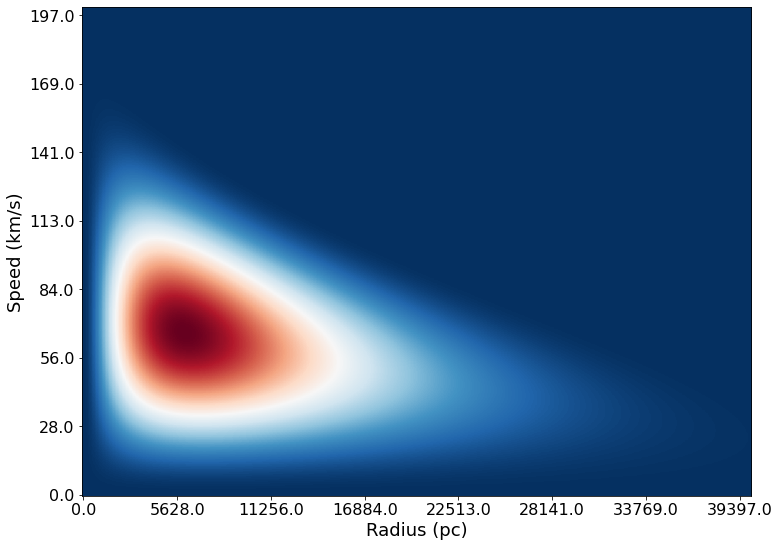

In [57]:
fig, ax1 = plt.subplots(figsize=(12,9))
ax1.imshow(np.transpose(PDFimage),origin='lower',aspect='auto',cmap='RdBu_r')

num_x_labels = 8
step_r = int(nRadii/(num_x_labels-1))
ax1.set_xticks(np.arange(0,nRadii,step_r))
ax1.set_xticklabels(np.round(radii[::step_r]))
ax1.set_xlabel('Radius (pc)')

num_y_labels = 8
step_s = int(nSpeeds/(num_y_labels-1))
ax1.set_yticks(np.arange(0,nSpeeds,step_s))
ax1.set_yticklabels(np.round(speeds[::step_s]))
ax1.set_ylabel('Speed (km/s)')